# Interpretable ML for Hydration Free Energy Prediction

**A Hands-On Workshop**


**Marvin V Prakash**  
Computational Scientist & Full-Stack Architect

-   Dual degree in **Computer Science** and **Computational Biology** (JNU), specializing in **machine learning** for biomolecular systems (force fields, protein-ligand interactions).
-   Published first-author research in the _ACS Journal_ on **hydration free energy prediction** using interpretable ML models (7 parameters vs. 200+).
-   Building **HAC-Net** (unpublished) for protein-ligand affinity prediction and scalable platforms (financial analytics, lab ecosystems) with **React, FastAPI, AWS**.
-   Founder of a web consultancy delivering secure cloud solutions (**AI authentication**, encryption) and mentor to 250+ students in tech initiatives.

<!-- Adding  a few images  -->

![JNU](images/jnu.png)
![dbt](images/dbt.jpg)


![paper](images/paper.png)
![acs](images/acs.png)


![morhpotech](images/morphotech.png)


## Why Estimate Hydration/Solvation Energy with ML?

**What is it?**

Imagine putting a molecule into water (hydration) or another liquid (solvation). The hydration/solvation energy is the energy change when that happens.

-   It's the energy _in_ the liquid _minus_ the energy in empty space.
-   A negative value means the molecule _likes_ being in the liquid.
-   It's all about how the molecule interacts with the liquid (e.g., attractions, repulsions).

**Why is it useful?**

1.  **Drug Discovery:**

    -   **Will the drug dissolve?** Hydration energy helps predict if a drug will dissolve in the body.
    -   **Will the drug bind strongly?** It affects how well a drug sticks to its target.
    -   **How to make better drugs?** Helps design drugs with better properties.

2.  **Materials Science:**

    -   **Which liquid to use?** Helps choose the right liquid to process materials.
    -   **How will it assemble?** Predicts how materials will self-assemble in solution.

3.  **Chemical Engineering:**

    -   **How to separate chemicals?** Influences how chemicals separate in processes.
    -   **How fast will the reaction go?** Solvents affect reaction speeds.

4.  **Environmental Science:**

    -   **Where do pollutants go?** Helps predict how pollutants move in the environment.

**Why use Machine Learning (ML)?**

-   **Faster than traditional methods:** ML is much faster than complex simulations.
-   **Good accuracy:** ML can be as accurate, or even more accurate, than some traditional methods.
-   **Learns complex patterns:** ML can find relationships that are hard to see with simple models.

**In short:** Estimating hydration/solvation energy is important for many fields, and ML provides a fast and accurate way to do it!

-   [Hydration Energy - LibreTexts](<https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Thermodynamics/Energies_and_Potentials/Enthalpy/Hydration>)


## 📋 Overview

This notebook guides you through analyzing physicochemical features and hydration free energy (`dG_exp`) data using **exploratory data analysis (EDA)** and **grouping strategies**. By the end, you'll:

-   Understand key descriptors (polar surface area, logP, etc.)
-   Visualize distributions, correlations, and outliers
-   Group molecules by chemical properties and analyze trends


## 🧪 Dataset Description

We’ll use a curated dataset from the **FreeSolv database**, containing:

-   **Target**: Experimental hydration free energy (`dG_exp`)
-   **Features**:

    -   `pol`: Polarization energy. This describes how easily the electron distribution of a molecule is distorted by an external electric field. It reflects the molecule's ability to respond to its environment.
    -   `psa`: Polar Surface Area. The surface area of the molecule that is made up of polar atoms (usually oxygen and nitrogen). It's related to how well the molecule can form hydrogen bonds.
    -   `logP`: The logarithm of the partition coefficient. It measures how well a molecule dissolves in oil versus water. A higher `logP` means the molecule prefers oil (is more hydrophobic), and a lower `logP` means it prefers water (is more hydrophilic).
    -   `n_donors`: The number of hydrogen bond donors in the molecule. These are atoms (usually oxygen or nitrogen with a hydrogen attached) that can donate a hydrogen bond to another molecule.
    -   `n_acceptors`: The number of hydrogen bond acceptors in the molecule. These are atoms (usually oxygen or nitrogen) that can accept a hydrogen bond from another molecule.

    -   `nrotb`: Number of rotatable bonds. This counts the number of single bonds in the molecule that can rotate freely. More rotatable bonds usually mean the molecule is more flexible.

-   **Metadata**: `mobleyID` (unique molecule identifier), `group_id` (chemical category)

-   **Reference**: [Molecular Descriptors & Ligand Efficiency Metrics Table](https://www.rgdscience.com/index.php/molecular-descriptors-ligand-efficiency-metrics/)


### Polar Electrostatic energy

![title](images/polarization_energy.png)


### Polar Surface Area

![title](images/psa.png)


In [5]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from rich.console import Console
from rich.jupyter import print
from rich.table import Table

#
from scipy.stats import pearsonr, skew
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import PowerTransformer, StandardScaler

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [6]:
df = pd.read_csv("data/groups/0.1/grouped_data.csv")
df.head()

,mobleyID,pol,psa,n_donors,nrotb,group_id,dG_exp,n_acceptors,logP
0,mobley_7532833,-7.491408,23.79,0,0,7.0,-3.88,1,0.52988
1,mobley_2198613,-1.497948,0.00,0,0,4.0,-0.63,0,1.24510
2,mobley_9257453,-9.095077,20.23,1,0,5.0,-7.29,1,2.69900
3,mobley_755351,-13.409148,35.25,1,1,5.0,-7.29,2,1.27740
4,mobley_9729792,-3.356425,0.00,0,0,NaN,-0.99,0,2.05870


## 🏷️ Meaningful Group Mapping


In [7]:
console = Console()

# Map group_id to group names
group_names = {
    0: "Alkanol",
    1: "Alkanone",
    2: "Alkene",
    3: "Alkyl Alkanoate",
    4: "Halo Alkane",
    5: "Aromatic",
    6: "Aliphatic cyclic",
    7: "N-based Aliphatic",
}

# Add a new column for group names
df["group_name"] = df["group_id"].map(group_names)

## 🔍 Focused EDA with Explanatory Visualizations


In [8]:
# Create a table for group distribution
group_distribution = df["group_name"].value_counts().reset_index()
group_distribution.columns = ["Group Name", "Count"]

table = Table(title="Group Distribution")
table.add_column("Group Name", justify="left", style="cyan", no_wrap=True)
table.add_column("Count", justify="right", style="green")

for index, row in group_distribution.iterrows():
    table.add_row(row["Group Name"], str(row["Count"]))

console.print(table)

# Visualize the distribution of groups using Plotly
fig = px.bar(
    group_distribution,
    x="Group Name",
    y="Count",
    title="Distribution of Groups",
    labels={"Group Name": "Group Name", "Count": "Number of Molecules"},
    text_auto=True,
)

fig.update_traces(
    marker_color="lightseagreen",
    marker_line_color="rgb(8,48,107)",
    marker_line_width=1.5,
    opacity=0.6,
)

fig.update_layout(
    xaxis_title="Group Name", yaxis_title="Number of Molecules", template="plotly_white"
)

fig.show()

     Group Distribution      
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Group Name        ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Aromatic          │   250 │
│ Halo Alkane       │    85 │
│ Alkyl Alkanoate   │    35 │
│ Alkanone          │    27 │
│ Alkene            │    26 │
│ Alkanol           │    24 │
│ N-based Aliphatic │    12 │
│ Aliphatic cyclic  │    12 │
└───────────────────┴───────┘

In [9]:
# Display basic statistics using Rich
console.print("[bold magenta]Basic Statistics:[/bold magenta]")
df.describe()

Basic Statistics:

,pol,psa,n_donors,nrotb,group_id,dG_exp,n_acceptors,logP
count,643.000000,643.000000,643.000000,643.000000,471.000000,643.000000,643.000000,643.000000
mean,-9.583435,20.889207,0.343701,1.629860,4.097665,-3.806952,1.382582,1.926940
std,10.516359,23.806500,0.627811,1.971726,1.576090,3.846124,1.610850,1.491136
min,-103.116055,0.000000,0.000000,0.000000,0.000000,-25.470000,0.000000,-3.585400
25%,-11.689927,0.000000,0.000000,0.000000,4.000000,-5.730000,0.000000,1.123300
50%,-7.678724,17.070000,0.000000,1.000000,5.000000,-3.540000,1.000000,1.780100
75%,-3.611565,26.300000,1.000000,3.000000,5.000000,-1.220000,2.000000,2.569650
max,-0.049148,136.100000,6.000000,12.000000,7.000000,3.430000,9.000000,9.887600


In [10]:
# 1. Distribution of Experimental Free Energy (dG_exp)
fig1 = px.histogram(
    df,
    x="dG_exp",
    nbins=30,
    title="Distribution of Experimental Free Energy (dG_exp)",
    labels={"dG_exp": "Experimental Free Energy (dG_exp)"},
    color_discrete_sequence=["lightseagreen"],
)

fig1.update_layout(
    template="plotly_white",
    xaxis_title="Experimental Free Energy (dG_exp)",
    yaxis_title="Count",
)

# 2. Scatter Plot: Polarizability (pol) vs. Experimental Free Energy (dG_exp)
fig2 = px.scatter(
    df,
    x="pol",
    y="dG_exp",
    title="Polarizability (pol) vs. Experimental Free Energy (dG_exp)",
    labels={"pol": "Polarizability", "dG_exp": "Experimental Free Energy (dG_exp)"},
    color="group_name",
    hover_name="mobleyID",
    trendline="lowess",
)

fig2.update_layout(
    template="plotly_white",
    xaxis_title="Polarizability (pol)",
    yaxis_title="Experimental Free Energy (dG_exp)",
)

# 3. Box Plot: Experimental Free Energy (dG_exp) by Group
fig3 = px.box(
    df,
    x="group_name",
    y="dG_exp",
    title="Experimental Free Energy (dG_exp) by Group",
    labels={"group_name": "Group", "dG_exp": "Experimental Free Energy (dG_exp)"},
    color="group_name",
)

fig3.update_layout(
    template="plotly_white",
    xaxis_title="Group",
    yaxis_title="Experimental Free Energy (dG_exp)",
)

# Show all plots
fig1.show()
fig2.show()
fig3.show()

In [11]:
# 1. Correlation Plot (Square Heatmap)
corr_matrix = df[
    ["pol", "psa", "n_donors", "nrotb", "dG_exp", "n_acceptors", "logP"]
].corr()

fig1 = go.Figure(
    data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale="Viridis",
        colorbar=dict(title="Correlation"),
        zmin=-1,  # Ensure the scale is from -1 to 1
        zmax=1,
    )
)

# Add annotations for correlation values
annotations = []
for i, row in enumerate(corr_matrix.values):
    for j, value in enumerate(row):
        annotations.append(
            go.layout.Annotation(
                text=f"{value:.2f}",  # Format to 2 decimal places
                x=corr_matrix.columns[j],
                y=corr_matrix.columns[i],
                xref="x1",
                yref="y1",
                font=dict(color="white" if abs(value) > 0.5 else "black"),
                showarrow=False,
            )
        )

fig1.update_layout(
    title="Correlation Heatmap",
    template="plotly_white",
    xaxis_title="Features",
    yaxis_title="Features",
    annotations=annotations,
    width=600,  # Square layout
    height=600,
)


fig1.show()

In [12]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression

# List of features to plot against dG_exp
features = ["pol", "psa", "logP", "n_donors", "n_acceptors", "nrotb"]

# Create subplots
fig = make_subplots(
    rows=2,
    cols=3,  # 2 rows, 3 columns
    subplot_titles=[f"{feat} vs. dG_exp" for feat in features],
)

# Add scatter plots and estimator lines for each feature
for i, feat in enumerate(features):
    row = (i // 3) + 1  # Calculate row position
    col = (i % 3) + 1  # Calculate column position

    # Add scatter plot
    fig.add_trace(
        go.Scatter(
            x=df[feat],
            y=df["dG_exp"],
            mode="markers",
            marker=dict(color="lightseagreen", opacity=0.6),
            name=feat,
            showlegend=False,
        ),
        row=row,
        col=col,
    )

    # Add estimator line (linear regression)
    x = df[feat].values.reshape(-1, 1)
    y = df["dG_exp"].values
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    fig.add_trace(
        go.Scatter(
            x=df[feat],
            y=y_pred,
            mode="lines",
            line=dict(color="darkorange", width=2),
            name=f"{feat} Estimator",
            showlegend=False,
        ),
        row=row,
        col=col,
    )

# Update layout
fig.update_layout(
    title="Feature Relationships with Experimental Free Energy (dG_exp)",
    template="plotly_white",
    height=800,  # Adjust height for better visibility
    width=1200,  # Adjust width for better visibility
)

# Update axis labels
for i, feat in enumerate(features):
    row = (i // 3) + 1
    col = (i % 3) + 1
    fig.update_xaxes(title_text=feat, row=row, col=col)
    fig.update_yaxes(title_text="dG_exp", row=row, col=col)

# Show plot
fig.show()

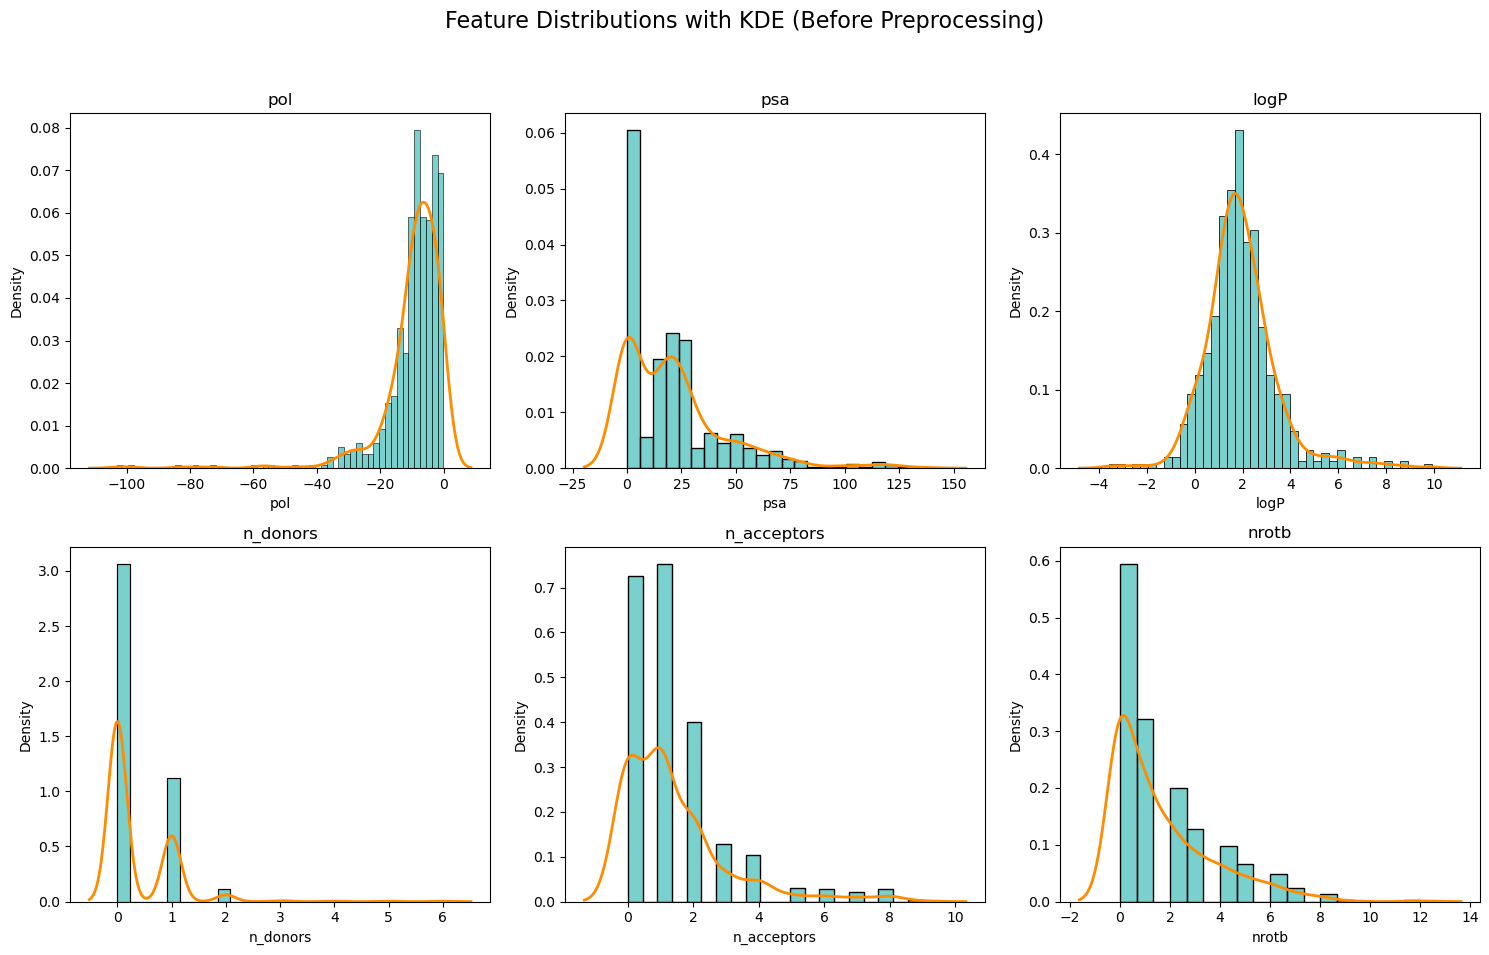

In [13]:
features = ["pol", "psa", "logP", "n_donors", "n_acceptors", "nrotb"]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2x3 array of axes for easy iteration

# Plot histograms and KDEs for each feature
for i, feat in enumerate(features):
    ax = axes[i]  # Get the current subplot axis

    # Drop NaN values
    x_data = df[feat].dropna()

    # Plot histogram
    sns.histplot(
        x=x_data,
        kde=False,  # Disable KDE in histplot
        stat="density",  # Normalize to density
        color="lightseagreen",
        ax=ax,
        alpha=0.6,
    )

    # Plot KDE (only if variance is greater than zero)
    if x_data.var() > 0:
        try:
            sns.kdeplot(
                x=x_data,
                color="darkorange",
                ax=ax,
                linewidth=2,
            )
        except np.linalg.LinAlgError:
            print(f"Singular matrix error for feature: {feat}")
    else:
        print(f"Skipping KDE for feature {feat} due to insufficient variance.")

    ax.set_title(feat)  # Set subplot title
    ax.set_xlabel(feat)  # Set x-axis label
    ax.set_ylabel("Density")  # Set y-axis label

fig.suptitle(
    "Feature Distributions with KDE (Before Preprocessing)", fontsize=16
)  # Overall title
plt.tight_layout(
    rect=[0, 0.03, 1, 0.95]
)  # Adjust layout to prevent overlap and make space for suptitle
plt.show()

## ⚙️ Simplified Preprocessing Pipeline


In [14]:
# Count nan again
df.isnull().sum()

mobleyID         0
pol              0
psa              0
n_donors         0
nrotb            0
group_id       172
dG_exp           0
n_acceptors      0
logP             0
group_name     172
dtype: int64

In [15]:
# Replace null 'group_id' values with 8
df["group_id"] = df["group_id"].fillna(8)

# Count nan again
df.isnull().sum()

mobleyID         0
pol              0
psa              0
n_donors         0
nrotb            0
group_id         0
dG_exp           0
n_acceptors      0
logP             0
group_name     172
dtype: int64

In [16]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, column="dG_exp"):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        data = df[self.column]
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(data >= lower_bound) & (data <= upper_bound)]
        return df


class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pol_transformer=None):
        self.pol_transformer = pol_transformer
        self.columns = [
            "pol",
            "n_acceptors",
            "n_donors",
            "nrotb",
            "psa",
        ]

    def fit(self, X, y=None):
        self.pol_transformer.fit(X[self.columns])
        return self

    def transform(self, X):
        X_ = X.copy()
        X_[self.columns] = self.pol_transformer.transform(X_[self.columns])
        return X_


class CustomStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        columns=[
            "pol",
            "psa",
            "logP",
            "n_acceptors",
            "n_donors",
            "nrotb",
        ],
    ):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X):
        X_ = X.copy()
        X_[self.columns] = self.scaler.transform(X_[self.columns])
        return X_


# Create the pipeline
preprocessing_pipeline = Pipeline(
    [
        ("outlier_remover", OutlierRemover()),
        (
            "custom_transformer",
            CustomTransformer(pol_transformer=PowerTransformer(method="yeo-johnson")),
        ),
        ("standard_scaler", CustomStandardScaler()),
    ]
)


# Assuming 'df' is your DataFrame
# Apply the pipeline
df_processed = preprocessing_pipeline.fit_transform(df)

print("Original shape:", df.shape)
print("Processed shape:", df_processed.shape)

# Check the first few rows of the processed data
print(df_processed.head())

# Verify the transformations
print("\nMean of scaled features:")
print(df_processed[["pol", "psa", "dG_exp", "logP"]].mean())
print("\nStandard deviation of scaled features:")
print(df_processed[["pol", "psa", "dG_exp", "logP"]].std())

print("\nSkewness of log-transformed 'pol':", skew(df_processed["pol"]))

Original shape:
(643, 10)

Processed shape:
(628, 10)

mobleyID       pol       psa  n_donors     nrotb  group_id  dG_exp  \
0  mobley_7532833 -0.127256  0.615801 -0.619032 -1.118819       7.0   -3.88   
1  mobley_2198613  1.271189 -1.248611 -0.619032 -1.118819       4.0   -0.63   
2  mobley_9257453 -0.344881  0.497294  1.609356 -1.118819       5.0   -7.29   
3   mobley_755351 -0.809301  0.921488  1.609356  0.079647       5.0   -7.29   
4  mobley_9729792  0.664935 -1.248611 -0.619032 -1.118819       8.0   -0.99   

   n_acceptors      logP         group_name  
0     0.146662 -1.023346  N-based Aliphatic  
1    -1.242242 -0.522037        Halo Alkane  
2     0.146662  0.497027           Aromatic  
3     0.810954 -0.499397           Aromatic  
4    -1.242242  0.048230                NaN

Mean of scaled features:

pol      -4.242891e-18
psa      -4.242891e-17
dG_exp   -3.483933e+00
logP      1.612298e-16
dtype: float64

Standard deviation of scaled features:

pol       1.000797
psa       1.000797
dG_exp    3.218252
logP      1.000797
dtype: float64

Skewness of log-transformed 'pol': -0.021759288228340883

In [17]:
features = ["pol", "psa", "n_donors", "nrotb", "n_acceptors", "logP"]
X = df_processed[features]
y = df_processed["dG_exp"]
groups = df_processed["group_id"]
id_column = "mobleyID"
n_splits = 4

In [18]:
# Count nan again
df_processed.isnull().sum()

mobleyID         0
pol              0
psa              0
n_donors         0
nrotb            0
group_id         0
dG_exp           0
n_acceptors      0
logP             0
group_name     159
dtype: int64

In [19]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

## 🤖 Model Training with Clear Validation


In [20]:
# Initialize model and evaluator
model = LinearRegression()
cv = GroupKFold(n_splits=4)

# Training loop
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    # Fold evaluation
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    print(f"Fold {fold + 1} | RMSE: {rmse:.2f} | R²: {r2:.2f}")

Fold 1 | RMSE: 1.97 | R²: 0.54

Fold 2 | RMSE: 1.75 | R²: 0.61

Fold 3 | RMSE: 1.33 | R²: 0.72

Fold 4 | RMSE: 1.26 | R²: 0.77